In [162]:
import torch
import torch.nn as nn
from torch.autograd.function import Function
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import StandardScaler


import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator

# Hyperparameters

In [181]:
hyperparam = {
    "data" : {
        "stake_training_data" : 0.75, 
        "path" : '../../data/vega_shrinkwrapper_original/'
    },
    "model" : {
        "input_size" : 7,
        "n_hidden" : 150,
        "sequence_size" : 20,
        "batch_size" : 1,
        "lstm_layer" : 3,
    },
    "cycling_lr" : {
        # step_size is the number of training iterations (total samples/batch_size) per half cycle. 
        # Authors suggest setting step_size 2-8 x training iterations in epoch.
        "step_size" : (1536/8)*2, 
        # Mode can be one of {triangular, triangular2, exp_range}
        "mode" : "triangular", 
        "gamma" : 0.9995,
        "base_lr" : 3e-3, 
        "max_lr" :0.1
    },
    "training": {
        "n_epochs" : 20,
        "patience" : 50,
    }
}

# Split train and test data

In [182]:
class DataPreperator():
    def __init__(self, path):
        self.path = path
        
    def load_data(self):
        return pd.read_csv(self.path)
    
    def preprocess_data(self, train_data, validation_data):
        # Remove time feature
        train_data = train_data.drop(labels="Timestamp", axis=1)
        validation_data = validation_data.drop(labels="Timestamp", axis=1)
        # Initialise standard scaler
        scaler = StandardScaler()
        scaler.fit(train_data)
        # Transform data
        train_preprocessed = scaler.transform(train_data)
        validation_preprocessed = scaler.transform(validation_data)
        return train_preprocessed, validation_preprocessed 
        
    def provide_data(self, stake_training_data):
        dataset = self.load_data()
        amount_training_data = round(len(dataset)*stake_training_data)
        train_data = dataset.iloc[0:amount_training_data,:]
        validation_data = dataset.iloc[amount_training_data:,:]
        train_preprocessed, validation_preporcessed = self.preprocess_data(train_data, validation_data)
        
        return train_preprocessed, validation_preporcessed

In [183]:
train_loader = DataPreperator(path=hyperparam['data']['path']+'NewBlade001.csv')
train_data, validation_data = train_loader.provide_data(stake_training_data=hyperparam['data']['stake_training_data'], )

# Datahandler 
Time series data must be transformed into a structure of samples with `input` and `target` components before it can be used to fit a supervised learning model. <br>
For a time series interested in one-step predictions, the observations at prior time steps, so-called lag observations, are used as `input` and the `target` is the observation at the current time step.

For example, a univariate series can be expressed as a supervised learning problem with three time steps for `input` and one step as `target`, as follows:

|input|target|
|-----|------|
[1, 2, 3]|[4]
[2, 3, 4]|[5]
[3, 4, 5]|[6]

The Keras deep learning library provides the `TimeseriesGenerator` to automatically transform both univariate and multivariate time series data into such a format. 

## Size of multivariate time series
Actually the data has a other size than in the table above because of multivariate time series data and because of using batches. <br>
__First dimension__: batch size --> Defines the number of samples that will be propagated through the network simultaneously. <br>
__Second dimension:__ timesteps --> Number of sequence which is passed into the LSTM <br>
__Third dimension:__ input_dim --> Is the number of features. In this case data from 7 sensors, collected at the same time. <br>

![](../../knowledge/pictures/input_shape.png)

In [184]:
class DataSet(Dataset):
    def __init__(self, data, timesteps):
        # All data are loaded from csv file and converted to an numpy array
        self.data = data
        # Data generator is initialized, batch_size=1 is indipendent of neural network's batch_size 
        self.generator = TimeseriesGenerator(self.data, self.data, length=timesteps, batch_size=1)

    def __getitem__(self, index):
        x, y = self.generator[index]
        x_torch = torch.from_numpy(x)
        # Dimension 0 with size 1 (created by TimeseriesGenerator because of batch_size=1) gets removed 
        # because DataLoader will add a dimension 0 with size=batch_size as well
        x_torch = torch.squeeze(x_torch) # torch.Size([1, timesteps, 7]) --> torch.Size([timesteps, 7])
        y_torch = torch.from_numpy(y)
        return (x_torch.float(), y_torch.float()) 

    def __len__(self):
        return len(self.generator)

In [185]:
dataset_train = DataSet(train_data, timesteps=hyperparam["model"]["sequence_size"])
dataset_validation = DataSet(validation_data, timesteps=hyperparam["model"]["sequence_size"])

data_loader_training = DataLoader(dataset_train, batch_size=hyperparam["model"]["batch_size"], 
                                  num_workers=1, shuffle=False, drop_last=True)
data_loader_validation = DataLoader(dataset_validation, batch_size=hyperparam["model"]["batch_size"], 
                                    num_workers=1, shuffle=False, drop_last=True)

## Define Architecture of Neural Network
__Parameters for LSTM Modul:__
- input_size : The number of expected features in the input x
- hidden_size :The number of features in the hidden state h
- num_layers : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results.
- batch_first : If True, then the input __and output__ tensors are provided as (batch, seq, feature).
- dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0

In [186]:
class LSTM(nn.Module):
    def __init__(self, batch_size, input_dim, n_hidden, n_layers):
        super(LSTM, self).__init__()
        # Attributes for LSTM Network
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        # Attribut for Gaussians
        self.n_gaus_param = 1
        
        # Definition of NN layer
        # batch_first = True because dataloader creates batches and batch_size is 0. dimension
        self.lstm = nn.LSTM(input_size = self.input_dim, hidden_size = self.n_hidden, num_layers = self.n_layers, batch_first = True)
        self.fc1 = nn.Linear(self.n_hidden, self.n_gaus_param * self.input_dim)
        
    def forward(self, input_data, hidden):
        # Forward propagate LSTM
        # LSTM in Pytorch return two results the first one usually called output and the second one (hidden_state, cell_state). 
        # As output the LSTM returns all the hidden_states for all the timesteps (seq), in other words all of the hidden states throughout
        # the sequence
        # As hidden_state the LSTM returns just the most recent hidden state
        lstm_out, (hidden_state, cell_state) = self.lstm(input_data, hidden)
        # Length of input data can varry 
        length_seq = input_data.size()[1]
        # Select the output from the last sequence 
        last_out = lstm_out[:,length_seq-1,:]
        out = self.fc1(last_out)
        return out
    
    def init_hidden(self):
        # This method is for initializing hidden state as well as cell state
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        h0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        c0 = torch.zeros(self.n_layers, self.batch_size, self.n_hidden, requires_grad=False)
        return [t for t in (h0, c0)]

## Initialize Model

In [187]:
model = LSTM(batch_size=hyperparam['model']['batch_size'], input_dim=hyperparam['model']['input_size'], 
             n_hidden=hyperparam['model']['n_hidden'], n_layers=hyperparam['model']['lstm_layer'])

## Cyclic Learning Rate
CLR is used to enhance the way the learning rate is scheduled during training, to provide better convergence and help in regularizing deep learning models. It eliminates the need to experimentally find the best values for the global learning rate. Allowing the learning rate to cyclically vary between lower and upper boundary values. The idea is to divide the training process into cycles determined by a stepsize parameter, which defines the number of iterations in half a cycle.
![](../../knowledge/pictures/scheduler.png)

### 1. Find base_lr and max_lr
Calculate the upper bound of the learning rate for your model. The way to do this is to:
1. Define an initial learning rate, the lower boundary of the range you want to test (let’s say 1e-7)
2. Define an upper boundary of the range (let’s say 0.1)
3. Define an exponential scheme to run through this step by step: <br>
```python
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (lr_find_epochs * len( data_loader["train"])))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
```
<br>
__Script for this is in: __  <br>
`find_base_and_max_lr.ipynb`

- A good upper bound (max_lr) is not on the lowest point, but about a factor of 10 to the left. (In this case 3e-3)
- A good lower bound (base_lr), according to the paper and other sources, is the upper bound, divided by a factor 6.

### 2. Implement cyclic learning rate with founded parameters

## Initialize optimizer and Cyclic Learning Rate

In [188]:
# lr=1. because of scheduler (1*learning_rate_schedular)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=hyperparam['cycling_lr']['base_lr'], 
                                              max_lr=hyperparam['cycling_lr']['max_lr'], step_size_up=hyperparam['cycling_lr']['step_size'], 
                                              mode=hyperparam['cycling_lr']['mode'], gamma=hyperparam['cycling_lr']['gamma'])

In [195]:
class OwnLossFunction(Function):

    @staticmethod
    # bias is an optional argument
    def forward(ctx, output, target_data):
        # Select and transform data
        target_data = torch.squeeze(target_data)
        ctx.save_for_backward(output, target_data)
        
        # Compute loss
        term = (target_data-output)**2
        loss_batches = torch.sum(input=term, dim=1)
        mean_loss = torch.sum(loss_batches)/hyperparam['model']['batch_size']
        return mean_loss
    
    @staticmethod
    def backward(ctx, grad_input):
        """
        grad_output = 1, because it is initialize by Optimizer 
        In the backward pass we need to compute the gradient of the loss
        with respect to the input.
        """
        output, target_data = ctx.saved_tensors # this is a tensor of models output
        grad_output = 2.*(output-target_data)
        #print(grad_output)
        return grad_output, None

### Loss function MSE

## Training Loop
An epoch consists of a learning cycle over all batches of training data and an evaluation of the most recent model with the testing data. 

In [194]:
print("Start model training")
# Create lists to save training loss and validation loss of each epoch
hist_training_loss = []
hist_validation_loss = []
lr_find_lr = []
epoch_training_loss = []
epoch_validation_loss = []

# Set first comparative value
lowest_loss = 99

for epoch in range(hyperparam["training"]["n_epochs"]+1):
    # Empty list for recording performance 
    epoch_training_loss = []
    epoch_validation_loss = []
    
    model.train()
    
    ##### Training #####
    for batch_number, data in enumerate(data_loader_training):
        # The LSTM has to be reinitialised, otherwise the LSTM will treat a new batch as a continuation of a sequence.
        # When batches of data are independent sequences, then you should reinitialise the hidden state before each batch. 
        # But if your data is made up of really long sequences and you cut it up into batches making sure that each batch 
        # follows on from the previous batch, then in that case you wouldn’t reinitialise the hidden state before each batch.
        # In the current workflow of class DataProvoider independent sequences are returned. 
        
        input_data, target_data = data
        
        hidden = model.init_hidden()
        
        # Zero out gradient, else they will accumulate between minibatches
        optimizer.zero_grad()
        
        # Forward propagation
        output = model(input_data, hidden)
         
        # Calculate loss
        loss = OwnLossFunction.apply(output, target_data)
        #loss = loss_function(output, target_data)
        #print(loss)
        #print("----------")
        epoch_training_loss.append(loss.item())
    
        # Backward pass
        loss.backward()
        params = list(model.parameters())
        #print(params)
        #print("----------")
        #print(params[0].grad)
        
        # Update parameters
        optimizer.step()
        
        # Update LR
        scheduler.step()
        lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
        lr_find_lr.append(lr_step)
    
    
    # Save mean of loss over all training iterations
    mean_epoch_training_loss = sum(epoch_training_loss) / float(len(epoch_training_loss))
    hist_training_loss.append(mean_epoch_training_loss)
    
    print("-------- epoch_no. {} finished with training loss {}--------".format(epoch, mean_epoch_training_loss))
        
    ##### Evaluation #######
    for input_data, target_data in data_loader_validation:
        # Change model to evaluation (prediction) mode
        model.eval()
        hidden = model.init_hidden()
        
        # Predict 
        output = model(input_data, hidden)
        
         # Calculate loss
        loss = OwnLossFunction.apply(output, target_data)
        #loss = loss_function(output, target_data)
        epoch_validation_loss.append(loss.item())
        
    # Save mean of loss over all validation iterations to epoch history  
    mean_epoch_validation_loss = sum(epoch_validation_loss) / float(len(epoch_validation_loss))
    hist_validation_loss.append(mean_epoch_validation_loss)
    
    print("-------- epoch_no. {} finished with eval loss {}--------".format(epoch, mean_epoch_validation_loss))
        
    # Check after every evaluation whether the latest model is the best one or not
    # If this is the case, set current score to best_score, reset trails and save the model.
    if mean_epoch_validation_loss < lowest_loss:
        trials = 0
        lowest_loss = mean_epoch_validation_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mean_epoch_validation_loss
        }, "../../models/best_model.pt")
        print("Epoch {}: best model saved with loss: {}".format(epoch, mean_epoch_validation_loss))
    
    # Else: Increase trails by one and start new epoch as long as not too many epochs 
    # were unsuccessful (controlled by patience)
    else:
        trials += 1
        if trials >= hyperparam['training']['patience'] :
            print(f'Early stopping on epoch {epoch}')
            break  

Start model training
-------- epoch_no. 0 finished with training loss nan--------
-------- epoch_no. 0 finished with eval loss nan--------


Traceback (most recent call last):
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/carlovoss/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [173]:
import numpy as np
import pandas as pd
x = range(len(lr_find_lr))
data = pd.DataFrame(data={'y': lr_find_lr, 'x': x})

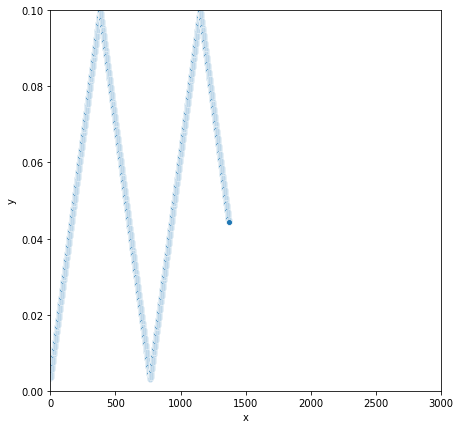

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(7, 7))
#ax.set(xscale="log")
plt.ylim(0, 0.1)
plt.xlim(0, 3000)

sns.scatterplot(x=data.x, y=data.y, ax=ax)
plt.show()

In [ ]:
epoch_no = range(len(epoch_training_loss))
loss = pd.DataFrame(data={'y': epoch_training_loss, 'x': epoch_no})
f, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x=loss.x, y=loss.y, ax=ax)
plt.show()